# Visualisation of the borsuk tool

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os.path
import statsmodels.api as sm
import statistics
import http.client
import json
import urllib.request
import requests
import random
from urllib import error
import configparser 

### Accessing the token
Pobranie danych dla kanału 

In [2]:
config = configparser.ConfigParser()
config.read("config.txt")

['config.txt']

In [3]:
http_client = config.get("configuration","http_client")
conn = http.client.HTTPConnection(http_client)
headers = {'Content-type': 'application/json'}

In [4]:
Username = config.get("configuration","user")
Password = config.get("configuration","password")

In [5]:
body = { 'Username': Username, 'Password': Password}
conn.request("POST","/auth/authenticate", json.dumps(body),headers)
response = conn.getresponse()
x = response.read().decode()
token = json.loads(x)['token']

### Loading the data set

In [6]:
url_data = config.get("configuration","url_data")

In [7]:
url = url_data + token

In [8]:
df = pd.read_csv(url, parse_dates=['time'])

In [9]:
df.head()

,time,value
0,2014-10-24 00:00:00,0.0
1,2014-10-24 00:05:00,0.0
2,2014-10-24 00:10:00,0.0
3,2014-10-24 00:15:00,0.0
4,2014-10-24 00:20:00,0.0


### Plotting the rainfall

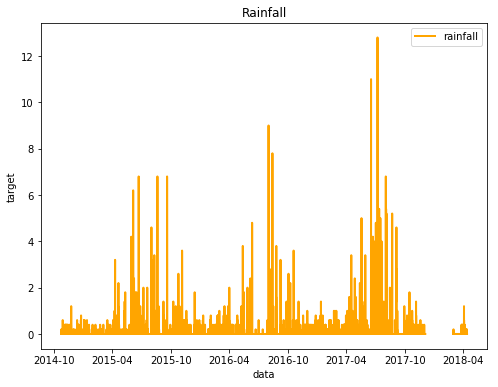

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(df['time'], df['value'], color="orange", label="rainfall", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Rainfall")
plt.legend()
plt.show()

### Taking the fragment of the data to the model

In [11]:
df_split = df[:300000]
df_split.head()

,time,value
0,2014-10-24 00:00:00,0.0
1,2014-10-24 00:05:00,0.0
2,2014-10-24 00:10:00,0.0
3,2014-10-24 00:15:00,0.0
4,2014-10-24 00:20:00,0.0


### Creating the json variable

In [12]:
df_json = df_split.to_json(orient='split')

In [13]:
values = df_split['value']
data = np.array(values)
data = data.tolist()

In [14]:
rainfall = {"rainfall":{"start-date": "2014-10-24", "resolution": "PT5M", "values": []}}

In [15]:
rainfall['rainfall']["values"].append(data)

In [16]:
json_data = json.dumps(rainfall)

In [17]:
json_data = json_data.replace('[[','[')
json_data = json_data.replace(']]',']')

In [18]:
json_data = json.loads(json_data)

### POST to borsuk alicja-test-model

In [19]:
my_url = config.get("configuration", "my_url")
body={"type":"storms-v0","id": "borsuk_test"}
response = requests.post(my_url, json=body)
print(response.status_code)
print(response.content) 

409
b'Error: Model with this id already exist.'


### GET to borsuk alicja-test-model

In [20]:
url_model = config.get("configuration", "url_model")
r = requests.get(url_model)
first = json.loads(r.content)['build']
print(first)

2


### POST to borsuk json data fragment

In [21]:
body = json_data
url_fit = config.get("configuration", "url_fit")
req = urllib.request.Request(url_fit)
req.add_header('Content-Type', 'application/json; charset=utf-8')
jsondata = json.dumps(body)
jsondataasbytes = jsondata.encode('utf-8') 
req.add_header('Content-Length', len(jsondataasbytes))
response = urllib.request.urlopen(req, jsondataasbytes)
print(response)

### GET alicja-test-model
The change of status informs that the post is finished

In [22]:
print("Primary status: ",first)

Primary status:  2


In [23]:
url = url_model

while True:
    r = requests.get(url)
    last = json.loads(r.content)['build']
    if last > first:
        print("Status after post: ",last)
        break

Status after post:  3


### GET storms with sessionWindow=PT10M

In [24]:
url_session = config.get("configuration", "url_session")
r = requests.get(url_session)
b = json.loads(r.content)

### Take storm with exemplary id

In [25]:
url = url_model + '/storm/4'
r = requests.get(url)
a = json.loads(r.content)
print(json.loads(r.content))

{'start-date': '2014-10-28T06:15', 'end-date': '2014-10-28T06:20', 'values': [0.20000000298023224, 0.20000000298023224]}


In [26]:
df[df['time'] > ('2014-10-28 06:10:00')].head()

,time,value
1227,2014-10-28 06:15:00,0.2
1228,2014-10-28 06:20:00,0.2
1229,2014-10-28 06:25:00,0.0
1230,2014-10-28 06:30:00,0.0
1231,2014-10-28 06:35:00,0.0
